## Полутехническая часть 

In [1]:
import datetime
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
source_orders = pd.read_csv('orders.csv')
source_customers = pd.read_csv('customers.csv')

In [3]:
source_orders.dtypes

id               int64
order_date      object
ship_mode       object
customer_id     object
sales          float64
dtype: object

In [4]:
source_orders['order_date'] = pd.to_datetime(source_orders['order_date'])
source_orders['order_year_month'] = source_orders['order_date'].dt.strftime('%Y-%m')

Т.к. постановка вопроса "на сколько сейчас все хуже, чем в прошлом году" не содержит прямых указаний года, нам надо понять какой год текущий и какой прошлый.

In [5]:
source_orders['order_date'].dt.year.unique()

array([2014, 2015, 2016, 2017])

Ага, понимаем что сейчас 2017 год. Поэтому мы сравниваем показатели за 2017 vs 2016. Поэтому нам надо будет по всем данным определить первое касание пользоватей, затем отобрать только новичков 16 и 17 года. При этом данные по продажам нам нужны по 16 и 17 году.

Но с таким подходом данных оказывается очень мало (заметим что если использовать все данные по продажам, оказывается есть месяцы в 16 и 17 году, когда новых по покупкам пользователей вообще не было), поэтому будем для определения когорт брать данные по продажам за 16-17 год по ним определять новичков.

In [6]:
orders = source_orders[source_orders['order_date'].dt.year >= 2016]
orders['order_date'].dt.year.unique()

array([2016, 2017])

In [7]:
customers_cohorts = orders.groupby('customer_id', as_index=False)['order_year_month'].min()
customers_cohorts.rename(columns = {'order_year_month':'m_cohort'}, inplace=True)
customers_cohorts['m_cohort'].sort_values().unique()

array(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype=object)

In [41]:
# собираем всё вместе
dataset = orders.merge(customers_cohorts, how='inner', on='customer_id')
dataset = dataset.merge(source_customers, how='inner', left_on='customer_id', right_on='id')\
                 .drop(['id_y'], axis=1)
dataset.rename(columns = {'id_x':'order_id'}, inplace=True)

# сделаем несколько датасетов для когорт отдельно по 16 и 17 году
dataset16 = dataset[(dataset['m_cohort'] < '2017-01') & (dataset['order_date'].dt.year == 2016)]
dataset17 = dataset[(dataset['m_cohort'] >= '2017-01') & (dataset['order_date'].dt.year == 2017)]

In [42]:
def m_cohort_idx(df):
    df['m_cohort_idx'] = np.arange(len(df))
    return df

In [58]:
def plot_retention(dataset, year):
    cohorts = dataset.groupby(['m_cohort', 'order_year_month']).agg({'customer_id': pd.Series.nunique})
    cohorts = cohorts.groupby(level=0).apply(m_cohort_idx)
    cohorts.reset_index(inplace=True)
    cohort_counts = cohorts.pivot(index='m_cohort',
                                     columns ='m_cohort_idx',
                                     values = 'customer_id')
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    
    sns.set(style='white')
    plt.figure(figsize=(14, 10))
    plt.title(f'Cohorts: costumer retention (by sales) {year}')
    sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.0%', cmap='Greens');


## Карты ретеншена

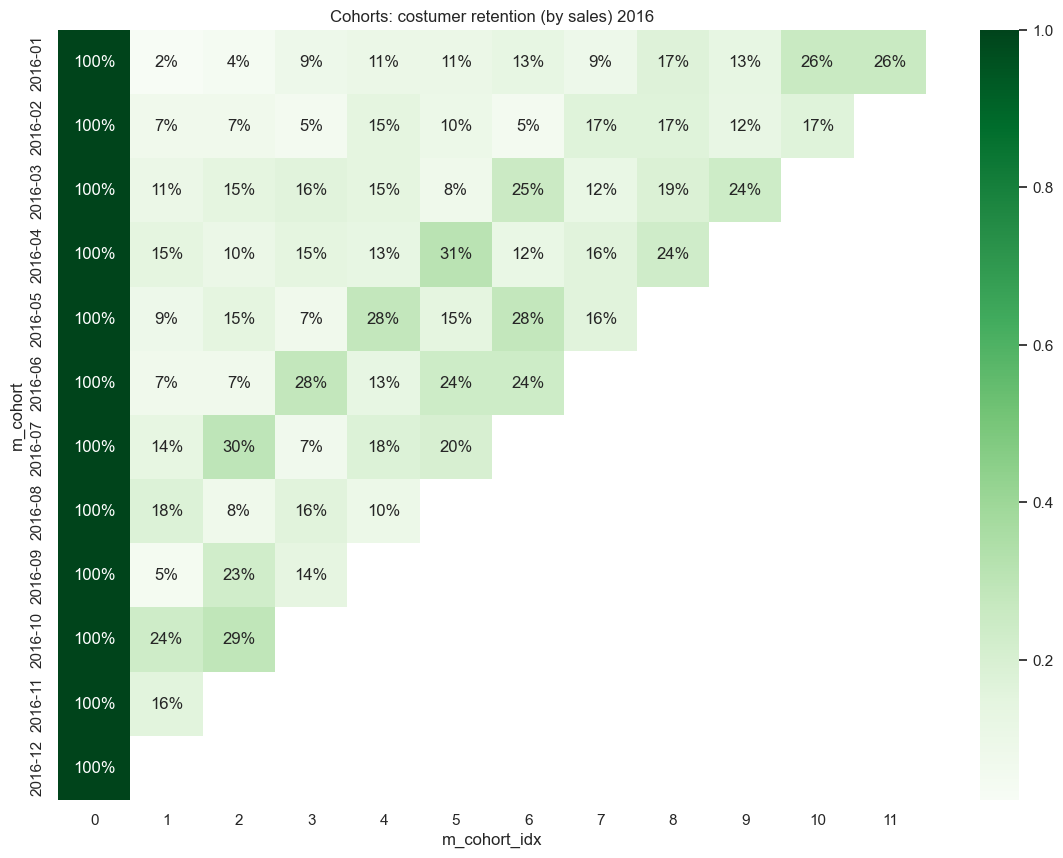

In [59]:
plot_retention(dataset16, '2016')

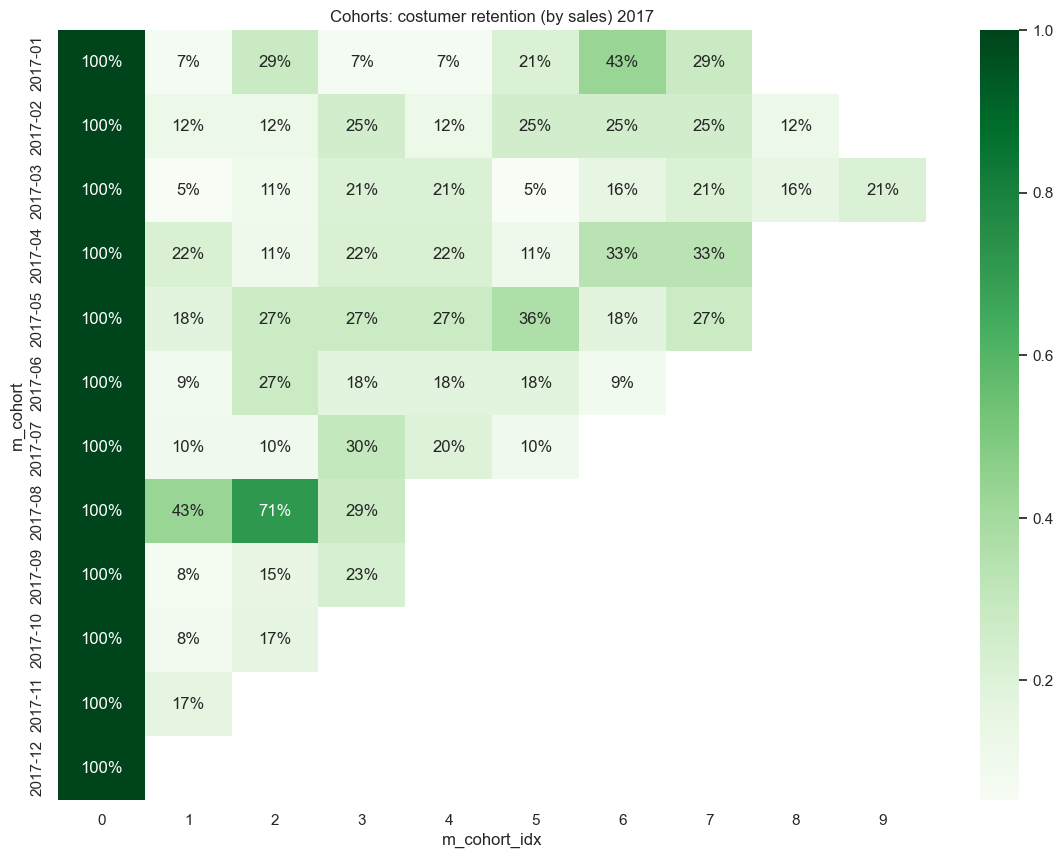

In [60]:
plot_retention(dataset17, '2017')

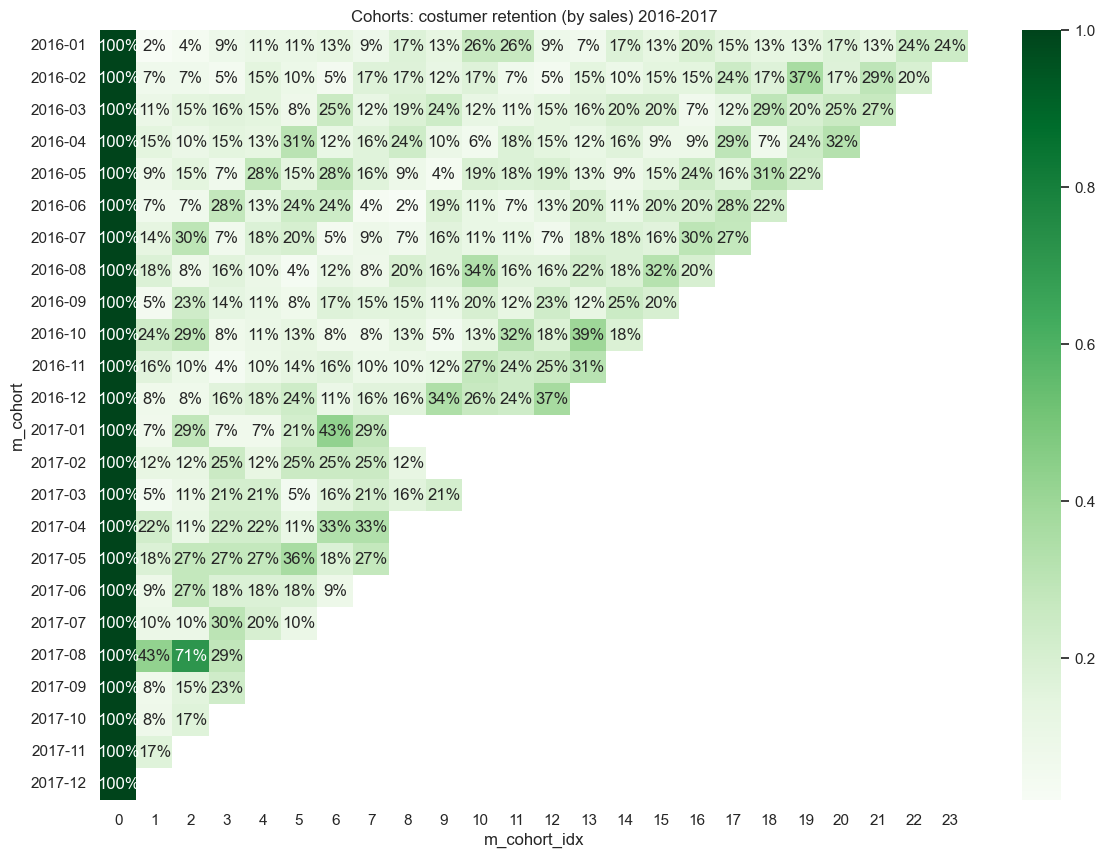

In [ ]:
plot_retention(dataset, '2016-2017')

## Многа букафф а-ля развернутый ответ

Если опустить найденный в задании концептуальный косяк (писал об этом выше) и сделать вид, что полученные данные ровно такие как и есть, то ответ на задание такой.

Из обращения (и его контекста) к нам стало понятно, что в данном случае продукт овнер подразумевает следующее (предпосылки): 
1. Под активными пользователями - те кто совершил покупку. 
2. Факт что пользователь вернулся или оттек - по наличию повторной покупки. 

Гипотеза исходя из "на сколько сейчас все хуже, чем в прошлом году" - возвращаемость клиентов в 2017 году хуже + количественное исчисление.
Данную гипотезу можно разбить на несколько составляющих.
1. Клиенты пришедшие в 17 году имеют более низкий ретеншн в течение года, чем пришедшие в 16.

    Для этого удобно смотреть как на визуализацию ретеншена отдельно по 16 и 17 году. так и на совмещенную визуализацию, ограничиваясь диапозоном годом. Так даже визуально заметно, что почти по всем когортам ретеншн выше, треугольник значительно зеленее (на совмещенной карте). Итого заключаем, что на годовом интервале новые пользователи 17 года, более возвращаемые.
    
2. Клиенты пришедшие в 16 году, не возвращаются в 17 (например как раз из-за проблем с доставкой)
    
    Можно заметить диагональ которая начинается на когорте 2016-01 спустя 14 месяцев и тянется по другим когортам. И еще одну уже спустся 20+ месяцев. Это может быть как триггерное или сезонное явление, так и будучи уже в 2017 году - быть положительным эффектом реактивации старых пользователей, что может опровергать этот пункт. В любом случае видно, что в 2017 году, часть пользователей из 16 все же возвращается.  
    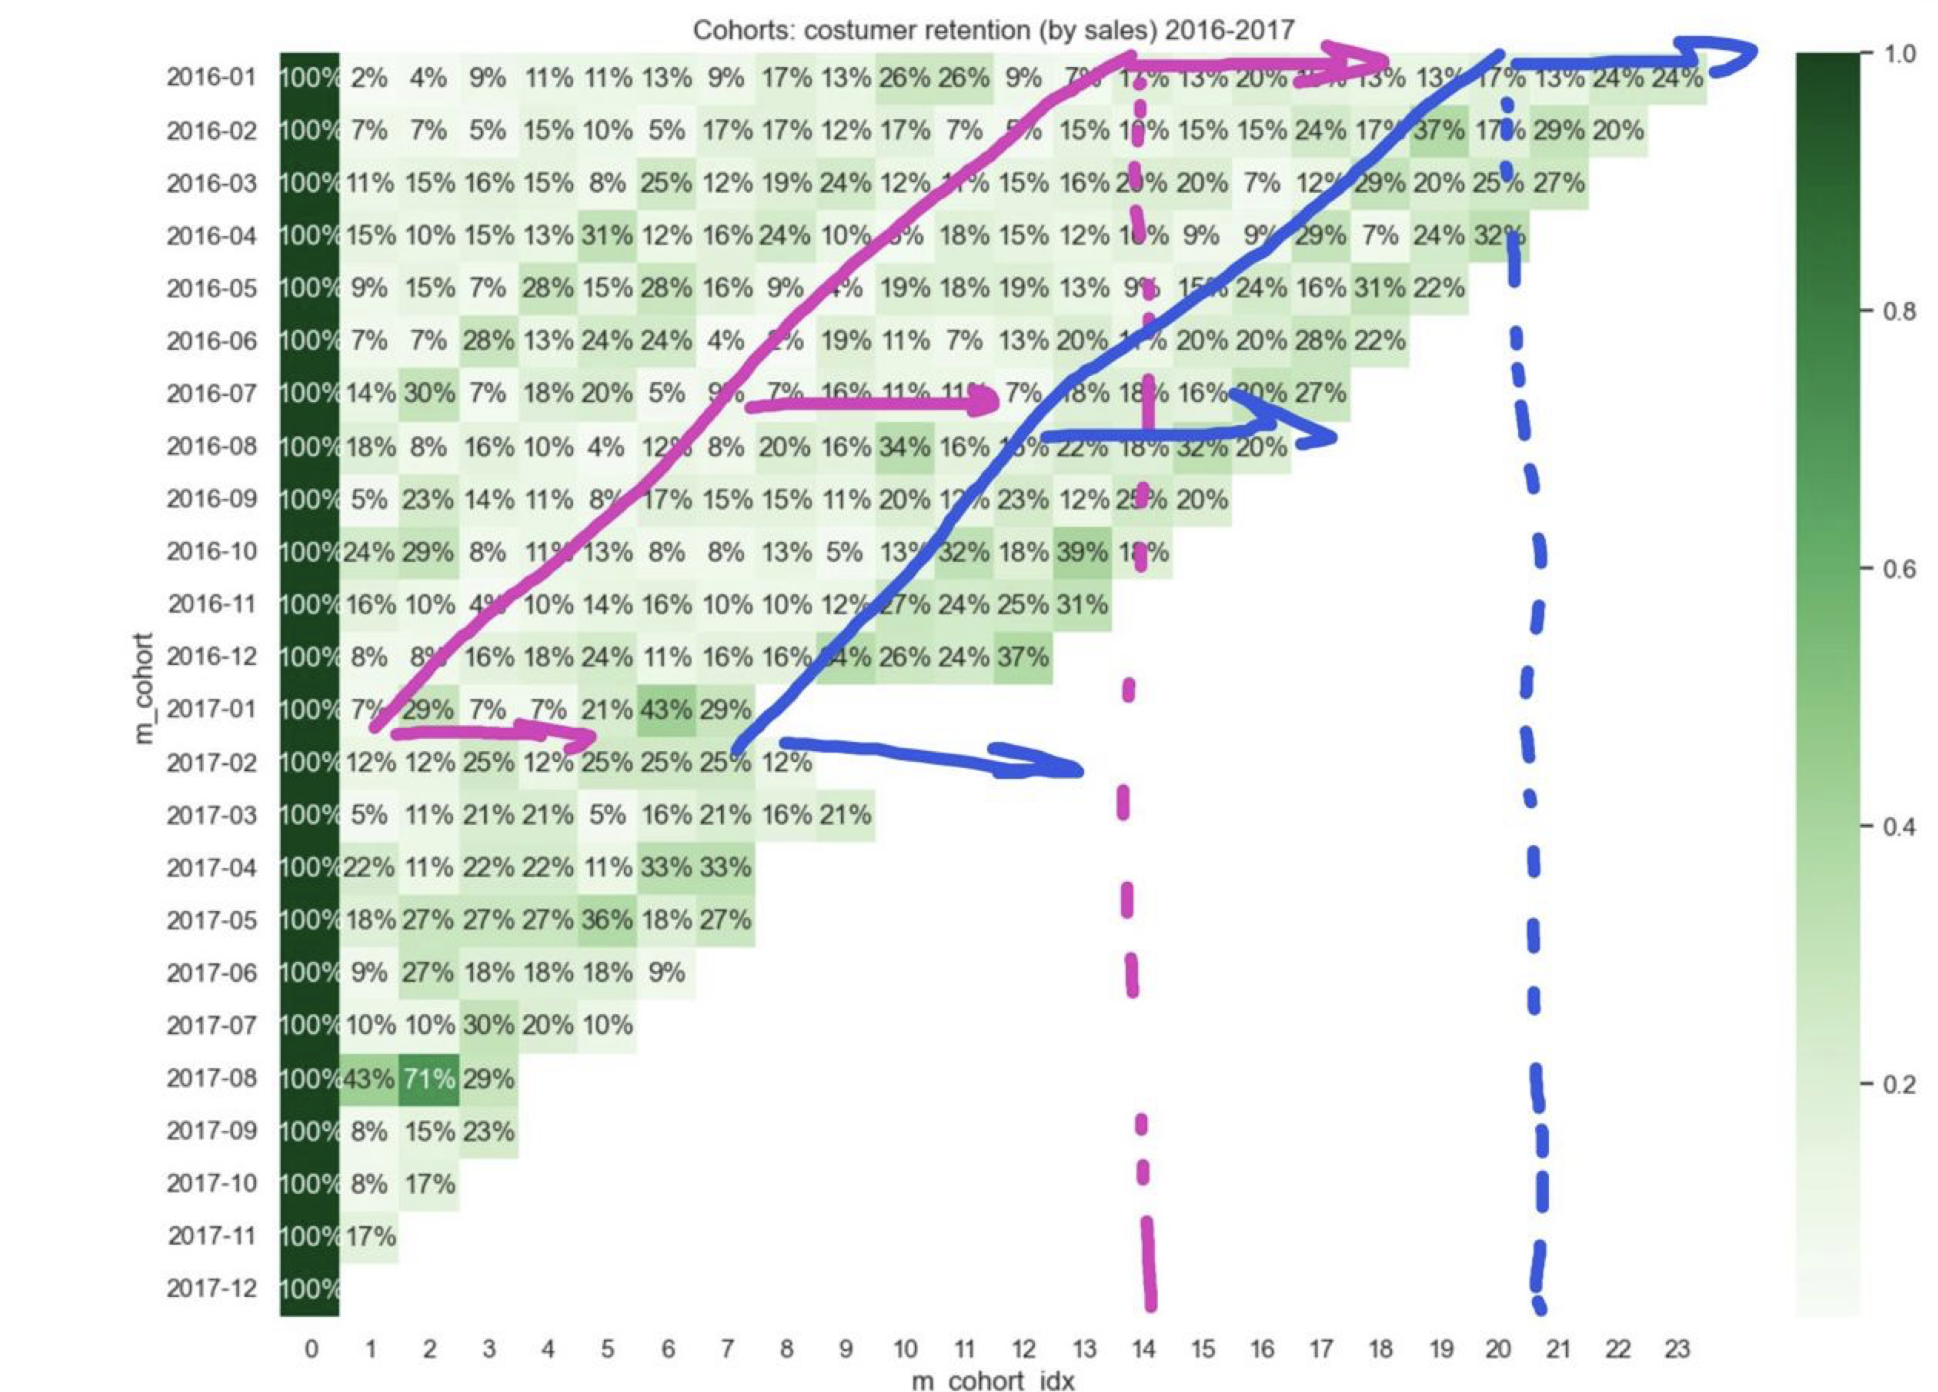

3. Численная разница 

    Несмотря на то, что визуально картина лучше, хорошо бы численно это посчитать. Ну у нас как бы MVP инструмента, поэтому всякие агрегации ретеншена реализовать не успели (но уже отложили в беклог). Усреднять ретенш между пользователями из 16 и 17 года можно по столбикам - получаем некую агрегацию ретеншену конкретного месяца, где на макроуровне оценим все когорты 16vs17. Либо можем сравнивать аналогичные месячные когорты по всей линии ретеншена и потом усреднять разницы либо подсчитывать число = число позеленевших когорт - число покрасневших. Также можно наверное попробовать усреднять и по строкам, получая тоже некоторую общую оценку. (еще можно наверное суммировать доли по всем ячейкам  в одинаковых по размерам треугольниках)
    Либо же использовать другие определения ретеншена. Например была ли покупка за весь интервал. Такой метод подсчета более подходит когда речь идет об оттоке. 
    
    
Также хотелось бы добавить комментарии к предпосылкам 1 и 2 + накидать пласт того, что еще можно отслеживать.

1. Для активных юзеров по покупкам нас может интересовать еще и сама конверсия в первую покупку для когорт как некоторый признак самой когорты. Ибо траффика и лидов мы не знаем, а на это вообще то тратим деньги. 
2. При этом как свойство когорты - абсолютное число юзеров в ней. Так вместе с конверсией мы должны понимать и метрики роста.
3. Кажется что данный подход с оттоком можно совместить с пониманием конверсии в повторную покупку (С2, С3 и прочее): так есть пользователи, которые вовсе не вернулись в продукт, а есть те, кто пришли но ничего не купили. Воздействовать можем как на первых, так и на вторых, как и понимать их соотношение по когорте. 
4. Кажется, что неплохо смотреть и на средний чек пользователей в когорте. Так помимо того, что мы просто будем видеть, что возможно к нам начинают приходить более ценные пользователи или продукт стал лучше, мы сможем лучше характеризовывать лояльных пользователей. 


Также хочется добавить, что нужно почекать данные, ибо в 2017 году есть дырки. 
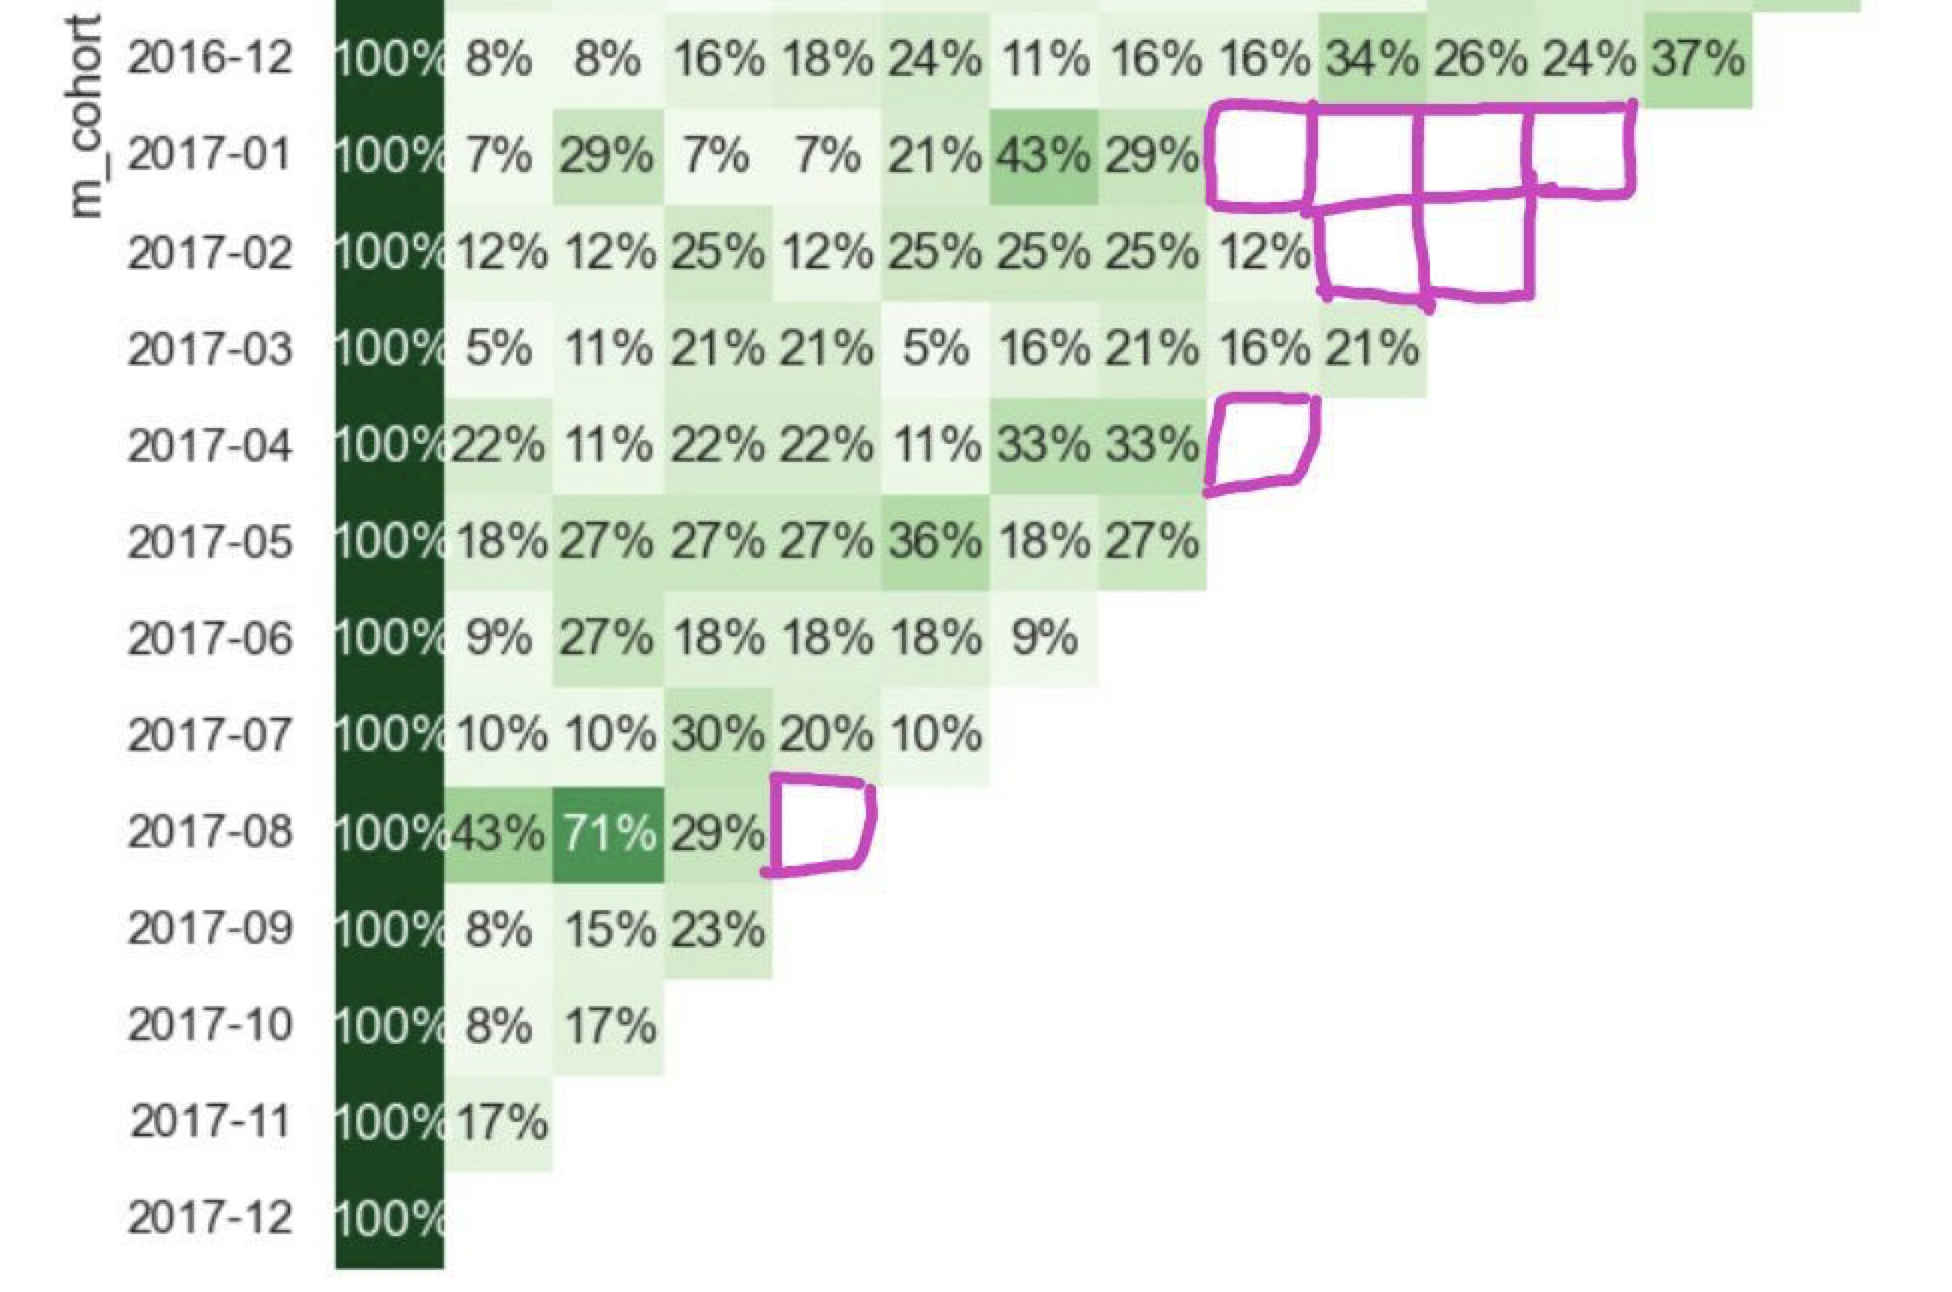


Итого получился MVP инструмент, который можно рассылать по почте раз в месяц, в котором уже много нагенерели гипотез что и как можно считать. Дальнейшее же развитие именно инструментария - это подготовка модели данных в хранилище и задача на реализацию этого добра в BI инструменте (ей бог хотел накидать в табло, но не успел).